# IMPORT

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit, prange
from os import listdir
from os.path import isfile, join
from scipy.integrate import cumtrapz

plt.style.use(['science', 'grid'])

DPI = 500

## Simulation Results

In [2]:
dir_names =  ['pso', 'apso', 'fpa_original', 'fpa']
param_names = ['kp', 'ki', 'kd']

data_loss = {}
data_loss_summary = {'name': [], 'min': [], 'max': [], 'mean': [], 'std': []}
data_best_loss_history = {}
data_best_param = {'name': []}
for param_name in param_names:
    data_best_param[param_name] = []

temp = np.Inf
    
for dir_name in dir_names:
    lh = np.load('../'+dir_name+'/result/loss_history.npy')
    ph = np.load('../'+dir_name+'/result/param_history.npy')
    lb = np.load('../'+dir_name+'/result/the_best_loss_history.npy')
    pb = np.load('../'+dir_name+'/result/the_best_param_history.npy')
    
    data_loss[dir_name] = lh
    
    data_best_loss_history[dir_name] = lb
    
    data_loss_summary['name'].append(dir_name)
    data_loss_summary['min'].append(lb[-1])
    data_loss_summary['max'].append(lh.max())
    data_loss_summary['mean'].append(np.mean(lh))
    data_loss_summary['std'].append(np.std(lh))
    
    data_best_param['name'].append(dir_name)
    for i in range(len(param_names)):
        data_best_param[param_names[i]].append(pb[-1][i])
        
    if lb[-1] < temp:
        alg_name = dir_name
        params = np.copy(pb[-1])
        temp = lb[-1]

df_loss = pd.DataFrame(data_loss)
df_loss_summary = pd.DataFrame(data_loss_summary)
df_best_param = pd.DataFrame(data_best_param)
df_best_loss_history = pd.DataFrame(data_best_loss_history)

print('The minimum loss algorithm: '+ alg_name)
print(params)

The minimum loss algorithm: pso
[0.91199774 1.58133774 0.03292953]


In [3]:
df_loss_summary

,name,min,max,mean,std
0,pso,0.000961,0.000961,0.000961,2.080708e-18
1,apso,0.000988,0.001861,0.001195,2.021491e-04
2,fpa_original,0.000961,0.000961,0.000961,1.665583e-18
3,fpa,0.000961,0.000961,0.000961,1.483417e-18


# Analysis (Cost: Mean Absolute Squared)

## Setpoint

In [4]:
def step(tt):
    out = np.zeros_like(tt)
    out[tt >= 0] = 1
    return out

def ramp(tt):
    out = np.array(tt)
    out[tt < 0] = 0
    return out

def jitter(gain, omega, tt, t0, tf):
    out = np.array(tt)
    
    out = gain * np.sin(omega*(tt-t0))
    out[tt-t0 < 0] = 0
    out[tt-tf > 0] = 0
    return out

No handles with labels found to put in legend.


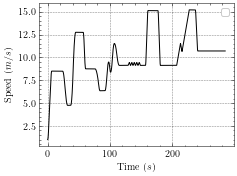

In [5]:
t0 = np.arange(3, 288, 0.02)
a0 = ramp(t0-3) - ramp(t0-4.5) - ramp(t0-8) + ramp(t0-9.5) \
    - 0.25*ramp(t0-27) + 0.25*ramp(t0-30) + 0.25*ramp(t0-32) - 0.25*ramp(t0-35) \
    + 0.5*ramp(t0-40) - 1.*ramp(t0-44) + 0.5*ramp(t0-48) \
    - 1*ramp(t0-60) + 2*ramp(t0 - 62) - 1*ramp(t0-64) \
    - 0.1*ramp(t0-79) + 0.4*ramp(t0-85) - 0.3*ramp(t0-87) \
    + 0.35*ramp(t0-95) - 0.7*ramp(t0-98) + 0.35*ramp(t0-101) \
    - 0.5*ramp(t0-101) + 1*ramp(t0-102.5) - 0.5*ramp(t0-104) \
    + 0.35*ramp(t0-104) - 0.7*ramp(t0-107) + 0.35*ramp(t0-110) \
    - 0.15*ramp(t0-110) + 0.3*ramp(t0-114) - 0.15*ramp(t0-118) \
    + jitter(0.25, np.pi / 2.0, t0, 132, 152) \
    + 2.*ramp(t0-160) - 2.*ramp(t0-161) - 2.*ramp(t0-163) + 2.*ramp(t0-164) \
    - 2.*ramp(t0 - 180) + 2*ramp(t0-181) + 2 *ramp(t0-183) - 2*ramp(t0-184) \
    + 2.0 * ramp(t0-210) - 2.0*ramp(t0-210.2) - 2.0*ramp(t0-216) + 2.0*ramp(t0-216.4)\
    + 2.0 * ramp(t0-218.4) - 2.0*ramp(t0-218.8)  - 2.0*ramp(t0 - 230) + 2.0*ramp(t0-230.2) \
    - 1.5*ramp(t0-240) + 1.5*ramp(t0-241) + 1.5*ramp(t0-243) - 1.5*ramp(t0-244) #\
    #+ 5.0*step(t0-255) - 5.0*step(t0-256)
t0 = np.arange(0, 285, 0.02)
v0 = cumtrapz(a0, t0, initial=0.) + 1.

plt.figure()
plt.plot(t0, v0, color='black')
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend()
plt.savefig('img/pid_tuning_setpoint.png', dpi=DPI, transparent=True)
plt.show()

## Model

In [6]:
# Steady State Response
param_ssr = np.load('../model/ssr.npy')[-1]

# Dynamics
param_dynamics = np.load('../model/sys_id.npy')[-1]

In [7]:
@njit
def delayed_control_signal(i, u, u_list, td):
    if i < td:
        ut = 0.0
    else:
        if td == 0:
            ut = u
        else:
            ut = u_list[i-td]
    return ut
_ = delayed_control_signal(1, 0.1, np.array([0.1, 0.2]), 0)

@njit
def clip(a, a_min, a_max):
    if a > a_max:
        return a_max
    elif a < a_min:
        return a_min
    else:
        return a
    
_ = clip(2.0, -1.0, 1.0)

# Steady state response parameters
beta1, beta2, beta3 = param_ssr

# System parameters
a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param_dynamics
td11 = int(np.around(td11))
td12 = int(np.around(td12))
td13 = int(np.around(td13))
td21 = int(np.around(td21))
td22 = int(np.around(td22))
td23 = int(np.around(td23))

sat_min = -1.
sat_max = 1.

@njit
def forward_propagation(t, v, param):    
    kp, ki, kd = param

    dt = np.mean(t[1:] - t[:-1])
    
    ki = ki * dt
    kd = kd / dt    
    
    e_sum = 0.0
    e_last = 0.0
    e_int_state = 0 # 0 --> No Saturation || 1 --> Saturation (+) || -1 --> Saturation (-1)
    is_start = True
    
    u1_list = np.empty(t.shape)
    u2_list = np.empty(t.shape)
    out = np.empty(t.shape)
    y = 0.0
    for i in range(t.shape[0]):     
        # LONGITUDINAL CONTROLLER
        sp = clip(v[i], 0.0, np.Inf)
        sr = beta1 * (1 - np.exp(beta2*sp)) + beta3
        sr = clip(sr, 0., sat_max) * 0.5
        
        err = sp - y
        if e_int_state == 0:
            e_sum += err
        elif e_int_state == 1:
            if err < 0:
                e_sum += err
        elif e_int_state == -1:
            if err > 0:
                e_sum += err
        
        if is_start:
            temp = sr + kp * err + ki * e_sum + 0.
            is_start = False
        else:
            temp = sr + kp * err + ki * e_sum + kd * (err - e_last)
        
        e_last = err

        if temp > sat_max: # Saturation (+)
            temp = sat_max
            e_int_state = 1
        elif temp < sat_min: # Saturation (-)
            temp = sat_min
            e_int_state = -1
        else: # Not saturated
            e_int_state = 0
        
        u1 = clip(temp, 0.0, sat_max)
        u2 = clip(-temp, 0.0, -sat_min)
        
        # DYNAMICS     
        u11t = delayed_control_signal(i, u1, u1_list, td11)
        u12t = delayed_control_signal(i, u1, u1_list, td12)
        u13t = delayed_control_signal(i, u1, u1_list, td13)
        u21t = delayed_control_signal(i, u2, u2_list, td21)
        u22t = delayed_control_signal(i, u2, u2_list, td22)
        u23t = delayed_control_signal(i, u2, u2_list, td23)
        
        temp = 0.
        if y != 0.:
            temp = a1
                    
        y_dot = temp + a2 * y + a3 * y**2 \
                + b1 * u11t + b2 * np.exp(b3 * y + b4 * u12t) * u13t  \
                + c1 * u21t + c2 * np.exp(c3 * y + c4 * u22t) * u23t
        
        y += y_dot * dt
        if y < 0.0:
            y = 0.0

        u1_list[i] = u1
        u2_list[i] = u2
        out[i] = y

    return out, u1_list, u2_list
_ = forward_propagation(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

## Visualization

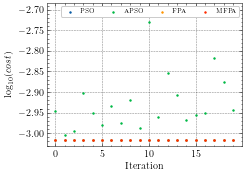

In [8]:
plt.figure()
names = ['PSO', 'APSO', 'FPA', 'MFPA']
for i in range(len(dir_names)):
    plt.scatter(df_loss.index.values, np.log10(df_loss[dir_names[i]]), s=2., label=names[i])
plt.xlabel('Iteration')
plt.ylabel('$\mathrm{log}_{10}(cost)$')
plt.legend(fontsize=6,  ncol=4, loc='upper right')
plt.ylim([None,-2.685])
plt.savefig('img/stability_check.png', dpi=DPI, transparent=True)
plt.show()

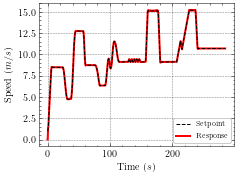

In [9]:
mv, cs1, cs2 = forward_propagation(t0, v0, params)

plt.figure()
plt.plot(t0, v0, label='Setpoint', zorder=2, color='black', linestyle='--')
plt.plot(t0, mv, label='Response', zorder=1, color='red', linewidth=2.)
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend(fontsize=7)
plt.savefig('img/simulation_result.png', dpi=DPI, transparent=True, bbox_inches='tight')
plt.show()

No handles with labels found to put in legend.


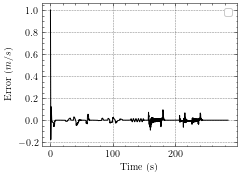

In [10]:
plt.figure()
plt.plot(t0, v0 - mv, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Error $(m/s)$')
plt.legend()
plt.savefig('img/simulation_error.png', dpi=DPI, transparent=True)
plt.show()

## CARLA Simulation

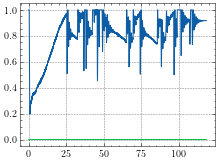

In [11]:
df = pd.read_csv('../additional/cost0/carla_sim.csv')
plt.plot(df.time, df.throttle)
plt.plot(df.time, df.brake)

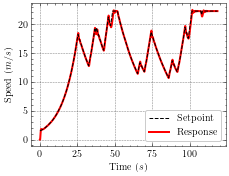

In [12]:
plt.figure()
plt.plot(df.time, df.sp_v, label='Setpoint', zorder=2, color='black', linestyle='--')
plt.plot(df.time, df.speed, label='Response', zorder=1, color='red', linewidth=2.)
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend()
plt.savefig('img/carla_result.png', dpi=DPI, transparent=True)
plt.show()

# Additional Simulation

In [13]:
@njit
def gradient(a, t):
    dt = np.mean(t[1:]-t[:-1])
    
#     forward = np.zeros_like(a)
#     forward[:-1] = a[1:]
#     forward[-1] = forward[-2]
#     backward = np.zeros_like(a)
#     backward[1:] = a[:-1]
#     backward[0] = backward[1]    
#     out = (forward - backward) / 2 / dt
    
    out = np.zeros_like(a)
    out[1:-1] = (a[2:] - a[:-2]) / 2 / dt
    out[0] = out[1]
    out[-1] = out[-2]
    return out
_ = gradient(v0, t0)

@njit
def mean_squared_error(t, v, param):
    mv, _, _ = forward_propagation(t, v, param)
    error = v - mv
    cost = np.mean(error**2)
    return cost
_ = mean_squared_error(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_absolute_u_dot(t, v, param):
    mv, cs1, cs2 = forward_propagation(t, v, param)
    
    cs1_dot = gradient(cs1, t)
    cs2_dot = gradient(cs2, t)
    return np.mean(np.abs(cs1_dot)**2+np.abs(cs2_dot)**2)
_ = mean_absolute_u_dot(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

In [14]:
# lamda_gain = [[1, 5, 10, 20, 30],
#               [1, 10, 20, 30, 40],
#               [1, 5, 10, 15, 20]]
lamda_gain = [[1, 10, 30],
              [1, 20, 40],
              [1, 10, 20]]
data_summary = {'type': [], 'lambda': [],
                'kp': [], 'ki': [], 'kd': [],
                'mse_train': [], 'mse_test': [],
                'mae_u_dot_train': [], 'mae_u_dot_test': []}
for i in range(1, 4):
    for j in lamda_gain[i-1]:
        exec(f"df{i}{j}=pd.read_csv('../additional/cost{i}/lamda_0_{j}/carla_sim.csv')")
        exec(f"err = df{i}{j}.ev.values")
        exec(f"throttle = df{i}{j}.throttle.values")
        exec(f"tsim = df{i}{j}.time.values")
        exec(f"pid_param = np.load('../additional/cost{i}/lamda_0_{j}/the_best_param_history.npy')[-1]")
        data_summary['type'].append(i)
        data_summary['lambda'].append(j)
        data_summary['kp'].append(pid_param[0])
        data_summary['ki'].append(pid_param[1])
        data_summary['kd'].append(pid_param[2])
        data_summary['mse_train'].append(mean_squared_error(t0, v0, pid_param))
        data_summary['mse_test'].append(np.mean(err**2))
        data_summary['mae_u_dot_train'].append(mean_absolute_u_dot(t0, v0, pid_param))
        data_summary['mae_u_dot_test'].append(np.mean(np.abs(np.gradient(throttle, tsim))))
        
df_summary = pd.DataFrame(data_summary)

In [15]:
df_summary

,type,lambda,kp,ki,kd,mse_train,mse_test,mae_u_dot_train,mae_u_dot_test
0,1,1,0.868324,1.309858,0.034897,0.000986,0.040908,0.014516,0.214131
1,1,10,1.148113,0.003583,0.057037,0.057035,0.026813,15.162113,0.221209
2,1,30,0.471461,0.000476,0.058301,0.423748,0.035788,1.826586,0.156041
3,2,1,0.397459,0.773776,0.027342,0.001931,0.047988,0.001830,0.154461
4,2,20,0.296189,0.386369,0.022363,0.004343,0.051247,0.001291,0.110814
5,2,40,0.279533,0.285842,0.020807,0.006198,0.054572,0.001227,0.101642
6,3,1,0.411328,0.629758,0.037844,0.002165,0.037689,0.001824,0.142419
7,3,10,0.325759,0.159262,0.033084,0.009162,0.043358,0.001297,0.110939
8,3,20,0.294440,0.087239,0.031503,0.016824,0.048125,0.001175,0.104195


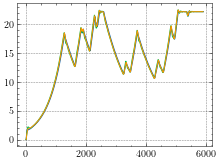

In [16]:
plt.plot(df110.speed)
plt.plot(df220.speed)
plt.plot(df310.speed)

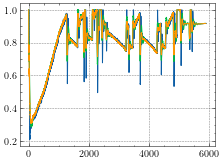

In [17]:
plt.plot(df110.throttle[:])
plt.plot(df220.throttle[:])
plt.plot(df310.throttle[:])

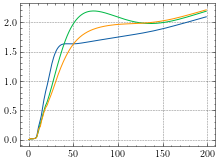

In [18]:
plt.plot(df110.speed[:200])
plt.plot(df220.speed[:200])
plt.plot(df310.speed[:200])

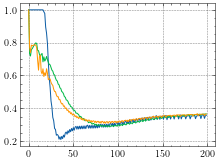

In [19]:
plt.plot(df110.throttle[:200])
plt.plot(df220.throttle[:200])
plt.plot(df310.throttle[:200])
# plt.ylim(0.2, 0.5)

## Plot Comparison 1

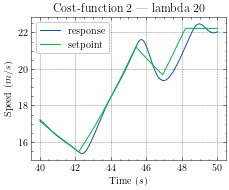

In [20]:
start = 2000
stop = 2500
plt.plot(df220.time[start:stop], df220.speed[start:stop], label='response')
plt.plot(df220.time[start:stop], df220.sp_v[start:stop], label='setpoint')
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend()
plt.title('Cost-function 2 | lambda 20')
plt.savefig('img/1cf_220.png', dpi=600, transparent=True)
plt.show()

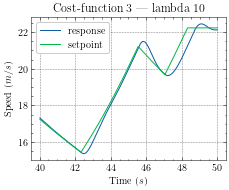

In [21]:
plt.plot(df310.time[start:stop], df310.speed[start:stop], label='response')
plt.plot(df310.time[start:stop], df310.sp_v[start:stop], label='setpoint')
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend()
plt.title('Cost-function 3 | lambda 10')
plt.savefig('img/1cf_310.png', dpi=600, transparent=True)
plt.show()

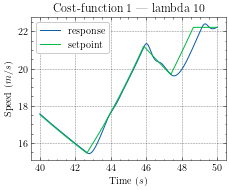

In [22]:
plt.plot(df110.time[start:stop], df110.speed[start:stop], label='response')
plt.plot(df110.time[start:stop], df110.sp_v[start:stop], label='setpoint')
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend()
plt.title('Cost-function 1 | lambda 10')
plt.savefig('img/1cf_110.png', dpi=600, transparent=True)
plt.show()

## Plot Comparison 2

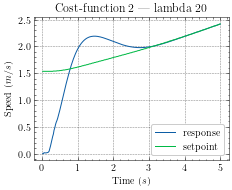

In [23]:
start = 0
stop = 250
plt.plot(df220.time[start:stop], df220.speed[start:stop], label='response')
plt.plot(df220.time[start:stop], df220.sp_v[start:stop], label='setpoint')
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend()
plt.title('Cost-function 2 | lambda 20')
plt.savefig('img/2cf_220.png', dpi=600, transparent=True)
plt.show()

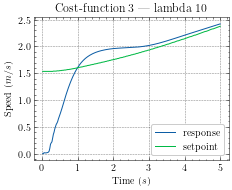

In [24]:
plt.plot(df310.time[start:stop], df310.speed[start:stop], label='response')
plt.plot(df310.time[start:stop], df310.sp_v[start:stop], label='setpoint')
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend()
plt.title('Cost-function 3 | lambda 10')
plt.savefig('img/2cf_310.png', dpi=600, transparent=True)
plt.show()

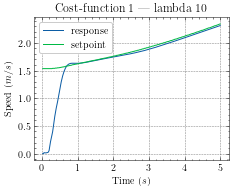

In [25]:
plt.plot(df110.time[start:stop], df110.speed[start:stop], label='response')
plt.plot(df110.time[start:stop], df110.sp_v[start:stop], label='setpoint')
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend()
plt.title('Cost-function 1 | lambda 10')
plt.savefig('img/2cf_110.png', dpi=600, transparent=True)
plt.show()

## Analysis if Using a Filter

In [26]:
wc = 2.*np.pi*5.

throttle_filtered = np.zeros_like(df110.throttle.values)
for i in range(1, throttle_filtered.shape[0]):
    throttle_filtered[i] = (throttle_filtered[i-1] + wc*0.02*df110.throttle.values[i])/(1 + wc*0.02)

(0.2, 0.5)

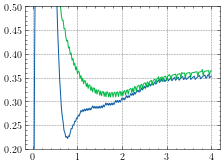

In [27]:
# plt.plot(df110.time[:200], df110.throttle[:200])
plt.plot(df110.time[:200], throttle_filtered[:200])
plt.plot(df310.time[:200], df310.throttle[:200])
plt.ylim(0.2, 0.5)

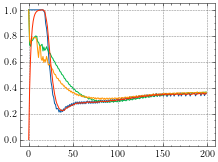

In [28]:
plt.plot(df110.throttle[:200])
plt.plot(df220.throttle[:200])
plt.plot(df310.throttle[:200])
plt.plot(throttle_filtered[:200])

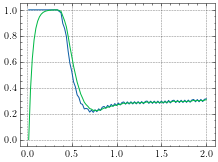

In [29]:
start = 0
stop = 100
plt.plot(df110.time[start:stop], df110.throttle[start:stop])
plt.plot(df110.time[start:stop], throttle_filtered[start:stop])